In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# nltk
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('twitter_new.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [4]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [6]:
df['target'].unique()  #Check unique Target Values

array([0, 4], dtype=int64)

In [15]:
df.target.value_counts()

0    800000
1    800000
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

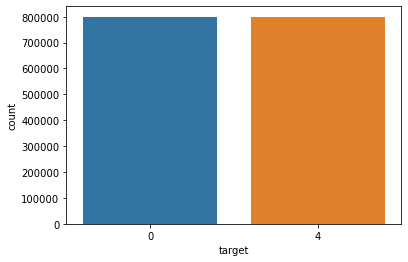

In [8]:
sns.countplot(x='target', data=df)

### Data Preprocessing 

In [9]:
df = df[['text','target']]     #Selecting the text and Target column for further analysis

In [10]:
df['target'] = df['target'].replace(4,1) #Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)

In [11]:
df

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1


In [12]:
#Data cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text,stem=False):
    # Remove link,user,special characters
    text = re.sub(TEXT_CLEANING_RE," ",str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

df['text'] = df['text'].apply(lambda x: preprocess(x))

In [13]:
#removing &quot and &amp after identifying them from wordcloud 
def cleaning_new(data):
    return re.sub('((amp[^s]+)|(quot[^s]+))',' ',data)
df['text'] = df['text'].apply(lambda x: cleaning_new(x))
df['text'].head(10)

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save 50 rest go ...
3                     whole body feels itchy like fire
4                                     behaving mad see
5                                           whole crew
6                                             need hug
7    hey long time see yes rains bit bit lol fine t...
8                                                 nope
9                                            que muera
Name: text, dtype: object

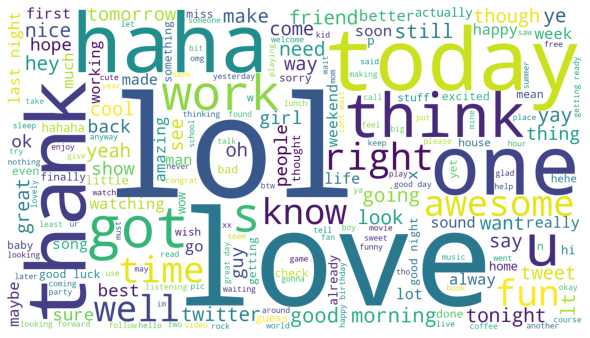

In [14]:
from wordcloud import WordCloud
word_cloud_df = df.loc[df['target'] == 1,:]  #"positive"/"negative"
all_words = ' '.join([text for text in word_cloud_df['text']])
 

wordcloud = WordCloud(width = 1600, height = 900, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

### Transforming Dataset using TF-IDF Vectorizer

In [16]:
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

from sklearn.feature_extraction.text import TfidfVectorizer
tdidf_v = TfidfVectorizer(stop_words='english',ngram_range =(1,3),tokenizer = token.tokenize)
text_counts = tdidf_v.fit_transform(df['text'])

In [17]:
X = text_counts
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state =5)

### Function For Model Evaluation

In [18]:
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Model Building

#### Model 1: Bernoulli Naive Bayes

              precision    recall  f1-score   support

           0       0.79      0.73      0.76    159789
           1       0.75      0.80      0.78    160211

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



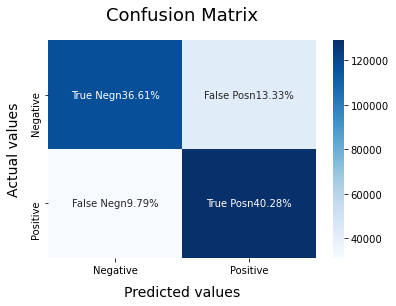

In [19]:
#Model 1
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

In [20]:
print("score on test: " + str(BNBmodel.score(X_test, y_test)))
print("score on train: "+ str(BNBmodel.score(X_train, y_train)))

score on test: 0.76885
score on train: 0.94901796875


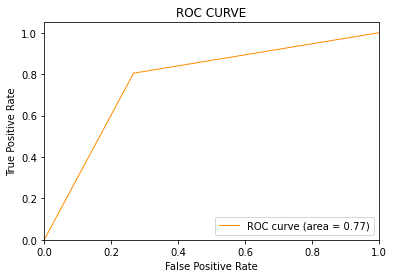

In [21]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

#### Model 2: Multinomial Naive Bayes

              precision    recall  f1-score   support

           0       0.77      0.78      0.77    159789
           1       0.78      0.76      0.77    160211

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



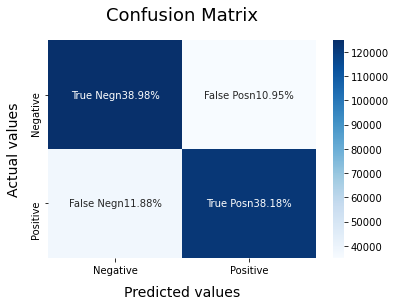

In [25]:
MNB=MultinomialNB()
MNB.fit(X_train,y_train)
model_Evaluate(MNB)
y_pred2 = MNB.predict(X_test)

In [26]:
print("score on test: " + str(MNB.score(X_test, y_test)))
print("score on train: "+ str(MNB.score(X_train, y_train)))

score on test: 0.771625
score on train: 0.94122265625


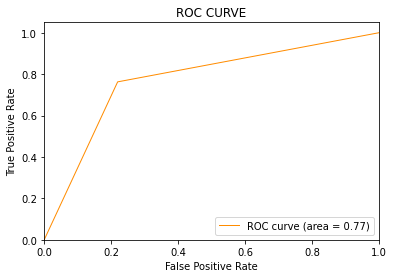

In [27]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

#### Model 3: Logistic Regression

              precision    recall  f1-score   support

           0       0.80      0.75      0.77    159789
           1       0.76      0.81      0.79    160211

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



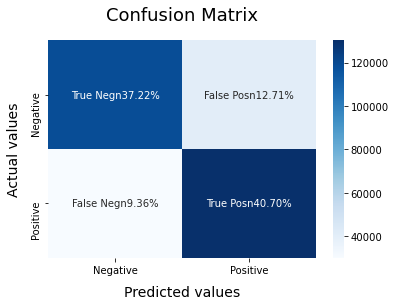

In [29]:
#Model 3
LRmodel = LogisticRegression()
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [30]:
print("score on test: " + str(LRmodel.score(X_test, y_test)))
print("score on train: "+ str(LRmodel.score(X_train, y_train)))

score on test: 0.77925625
score on train: 0.84198828125


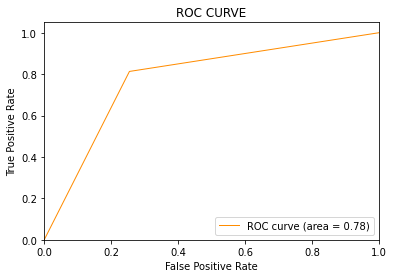

In [31]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Conclusion

- Logistic Regression performs better with an AUROC score of 0.78.
- Also the difference between training accuracy score and test accuracy score is comparitively less in Logistic Regression model.
- Therefore from the above three models Logistic Regression performs best.